In [1]:
!pip install tensorflow

In [2]:
import os
import json
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
def process_image(annotation, data_dir, label_mapping):
    image_index = annotation['image_index']
    chart_type = annotation['type']
    image_path = os.path.join(data_dir, 'png', f'{image_index}.png')

    # Load and process the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0  # Normalize

    label = label_mapping[chart_type]
    return image, label

In [4]:
def load_data(data_dir, subset_size=None):
    images = []
    labels = []
    label_mapping = {
        'vbar_categorical': 0,
        'hbar_categorical': 1,
        'dot_line': 2,
        'line': 3
    }

    # Load annotations
    annotations_path = os.path.join(data_dir, 'annotations.json')
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)

    # Subset sampling (if subset_size is specified)
    if subset_size is not None:
        annotations = random.sample(annotations, subset_size)  # Randomly sample the data

    # Load and process images
    for idx, annotation in enumerate(annotations):
        print(f"Loading image {idx+1}/{len(annotations)}")  # Print image number
        image, label = process_image(annotation, data_dir, label_mapping)
        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

In [5]:
import concurrent.futures

def load_dataset(split_name, subset_size):
    print(f"Loading {split_name} dataset with {subset_size} samples...")
    images, labels = load_data(os.path.join("..", "Plot QA Dataset", split_name), subset_size)
    print(f"{split_name} done")
    return images, labels

# Load datasets in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit tasks for train, validation, and test datasets
    future_train = executor.submit(load_dataset, 'train', 5000)
    future_val = executor.submit(load_dataset, 'validation', 5000)
    future_test = executor.submit(load_dataset, 'test', 5000)

    # Wait for all tasks to complete
    train_images, train_labels = future_train.result()
    val_images, val_labels = future_val.result()
    test_images, test_labels = future_test.result()

print("All datasets loaded successfully!")

Loading train dataset with 5000 samples...
Loading validation dataset with 5000 samples...
Loading test dataset with 5000 samples...
Loading image 1/5000
Loading image 1/5000
Loading image 1/5000
Loading image 2/5000
Loading image 2/5000
Loading image 2/5000
Loading image 3/5000
Loading image 3/5000
Loading image 3/5000
Loading image 4/5000
Loading image 4/5000
Loading image 4/5000
Loading image 5/5000
Loading image 5/5000
Loading image 5/5000
Loading image 6/5000
Loading image 6/5000
Loading image 6/5000
Loading image 7/5000
Loading image 7/5000
Loading image 7/5000
Loading image 8/5000
Loading image 8/5000
Loading image 8/5000
Loading image 9/5000
Loading image 10/5000
Loading image 9/5000
Loading image 9/5000
Loading image 10/5000
Loading image 11/5000
Loading image 10/5000
Loading image 11/5000
Loading image 11/5000
Loading image 12/5000
Loading image 12/5000
Loading image 12/5000
Loading image 13/5000
Loading image 13/5000
Loading image 14/5000
Loading image 13/5000
Loading image 

In [27]:
from tensorflow.keras import layers, models

model = models.Sequential()

# First Convolutional Layer
model.add(layers.Input(shape=(224, 224, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Block
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
#
# # # Fourth Convolutional Block
# # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # 4 labels in the final layer

# Compile the model
model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 18, 18, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       663,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 742,772 (2.83 MB)

 Trainable params: 742,772 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels),
                    epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 114s 711ms/step - accuracy: 0.6624 - loss: 0.7325 - val_accuracy: 0.9476 - val_loss: 0.1233
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 105s 667ms/step - accuracy: 0.9656 - loss: 0.0918 - val_accuracy: 0.9858 - val_loss: 0.0446
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 93s 593ms/step - accuracy: 0.9841 - loss: 0.0425 - val_accuracy: 0.9766 - val_loss: 0.0737
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 95s 605ms/step - accuracy: 0.9875 - loss: 0.0351 - val_accuracy: 0.9902 - val_loss: 0.0276
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 636ms/step - accuracy: 0.9947 - loss: 0.0151 - val_accuracy: 0.9896 - val_loss: 0.0304
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 106s 675ms/step - accuracy: 0.9967 - loss: 0.0082 - val_accuracy: 0.9934 - val_loss: 0.0167
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 106s 673ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9942 - val_loss: 0.0176
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 104s 660ms/step - accuracy: 0.9954 - l

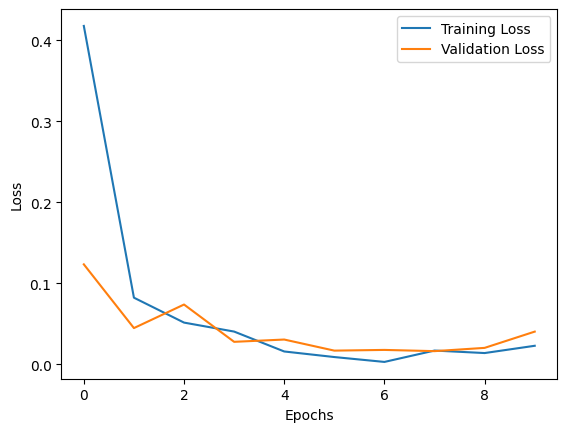

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9947 - loss: 0.0150
Test Accuracy: 0.99


In [26]:
def plot_images(images, true_labels, predicted_labels, class_names):
    num_images = len(images)

    # Increase the figure size (larger images)
    plt.figure(figsize=(20, 6))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

        # Get true and predicted labels
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[np.argmax(predicted_labels[i])]

        # Title with correct and predicted labels
        title_color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12, color=title_color, pad=10)

    plt.tight_layout()  # Automatically adjust subplot spacing
    plt.show()

In [11]:
# Randomly select 2 images per class
def get_random_images(images, labels, class_names, num_samples=2):
    class_indices = {cls: [] for cls in range(len(class_names))}
    for idx, label in enumerate(labels):
        class_indices[label].append(idx)

    selected_images = []
    selected_labels = []
    for cls, indices in class_indices.items():
        random_indices = random.sample(indices, num_samples)
        for idx in random_indices:
            selected_images.append(images[idx])
            selected_labels.append(cls)
    return np.array(selected_images), np.array(selected_labels)

In [31]:
class_names = ["vbar_categorical", "hbar_categorical", "dot_line", "line"]
images = test_images
labels = test_labels

# Get random images and their true labels
random_images, random_labels = get_random_images(images, labels, class_names)

# Make predictions
predictions = model.predict(random_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


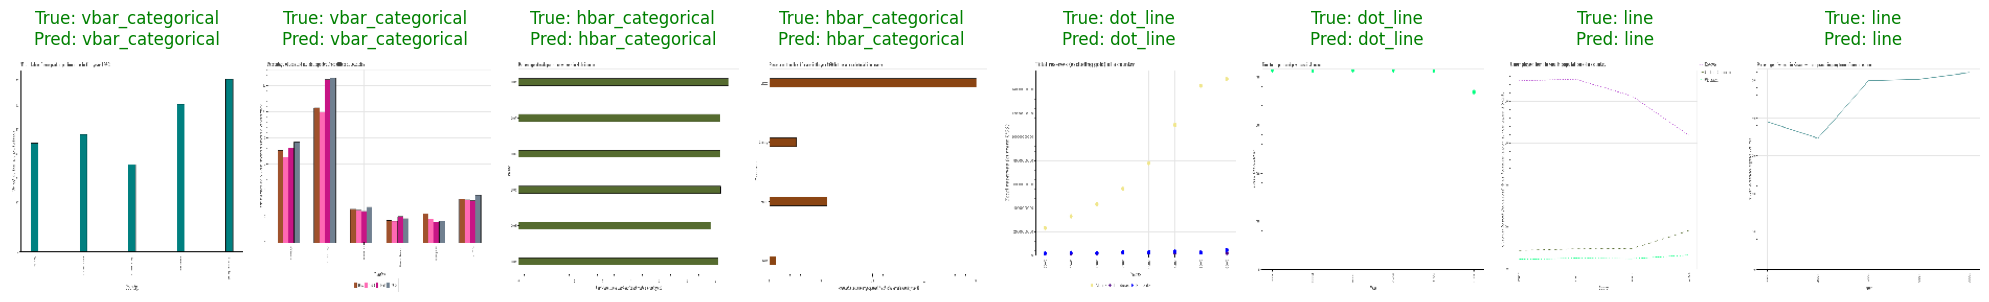

In [32]:
# Plot the images with true and predicted labels
plot_images(random_images, random_labels, predictions, class_names)

In [33]:
model.save('model.keras')